In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

stops = stopwords.words('english')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\akhil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akhil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Reading the given data

In [2]:
trials_data = pd.read_csv("us_trial.text", sep="/t,/n", header = None)
trials_data.columns = ['original_text']
print(trials_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


                                           original_text
0      A little throwback with my favourite person @ ...
1      glam on @user yesterday for #kcon makeup using...
2      Democracy Plaza in the wake of a stunning outc...
3       Then &amp; Now. VILO @ Walt Disney Magic Kingdom
4                   Who never... @ A Galaxy Far Far Away
...                                                  ...
49995  My #O2otd Love this chain so much and our new ...
49996  Met Santa and Olaf @ the North Pole today @ No...
49997  New York by Night Strideby #HERElocationNYC......
49998  Kisses for the birthday girl! @ Helzberg Diamonds
49999  Dinner with this priceless view!Thank you, S #...

[50000 rows x 1 columns]


In [3]:
trials_data['labels'] = pd.read_csv("us_trial.labels", sep="\t", header = None)


There are 50,000 records and corresponding labels, let's check the number of unique values in the target variable

## 2. check the number of unique values in the target variable

In [4]:
trials_data['labels'].unique()

array([ 0,  7, 11,  2,  1,  8, 13,  9, 16, 19,  4,  6, 14,  5, 10, 15,  3,
       12, 17, 18], dtype=int64)

There are 20 unique labels, let's check the value count for each label

In [5]:
trials_data['labels'].value_counts()

0     10760
1      5279
2      5241
3      2885
4      2517
5      2317
6      2049
7      1894
8      1796
9      1671
10     1544
11     1528
12     1462
14     1377
13     1346
16     1306
18     1286
17     1279
15     1249
19     1214
Name: labels, dtype: int64

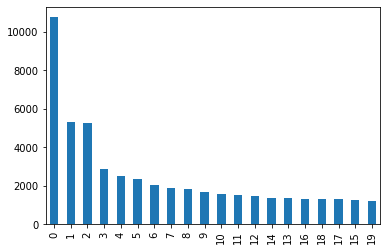

In [6]:
trials_data['labels'].value_counts().plot.bar(x='lab', y='val')

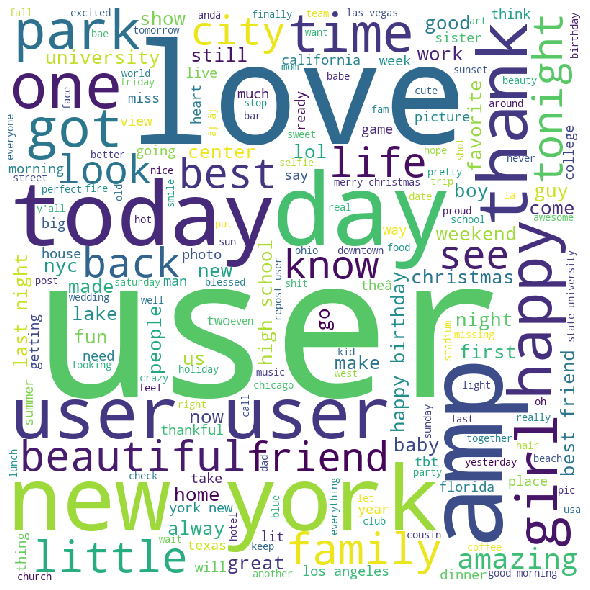

In [7]:
# Python program to generate WordCloud 

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in trials_data['original_text']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

looks like there are words like today, love, user, repost, new york etc., I think these might be tweets/posts of specific users and we may have to classify the person based on the matter of post/tweet

### Creating training and test sets

We'll be using 80% of the tweets (for each profile) for training and 20% for testing, i.e. a 80-20 split as mentioned in [this](http://snap.stanford.edu/soma2010/papers/soma2010_12.pdf) paper by Davison et al. Cross validation can and should be done.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(trials_data['original_text'], trials_data['labels'],
                                                    stratify=trials_data['labels'], 
                                                    test_size=0.20)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(40000,) (10000,) (40000,) (10000,)


## Preprocessing

In [10]:
#trials_data['hashtag'] = trials_data['original_text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [11]:
def preprocess_data(data, stops):
    #Removes Numbers
    data = data.astype(str).str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
 
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]

    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
            
    words = lower_text.apply(lemmatize_text)
    #print(words)
    words = words.apply(remove_punctuation)
    
    stop_words = set(stops)
    words = words.apply(lambda x: [item for item in x if item not in stop_words])
    
    #print(words)
    return pd.DataFrame(words)

X_train = preprocess_data(X_train, stops)

X_test = preprocess_data(X_test, stops)

In [12]:
X_train

,original_text
27463,"[reunited, bud, kent, state]"
13087,"[user, lit, room, way, user, user, present, ho..."
7486,"[random, rainy, friday, w, user, los, angeles,..."
6119,"[loved, user, nash, day, even, got, best, baes..."
11507,"[safe, say, shes, favorite, sss, monona, grove..."
...,...
10839,"[hello, c, washington, district, columbia]"
41587,"[corvette, racing, emblem, north, america, int..."
25340,"[thought, wa, really, pretty, censtudio, korea..."
48045,"[fox, theater, oakland]"


looks like there are words like today, love, user, repost, new york etc., I think these might be tweets/posts of specific users and we may have to classify the person based on the matter of post/tweet

# Set up helper functions for classification evaluation
It is important to choose an evaluation metric to compare our models. We will choose accuracy here however other metrics such as F-Measure can also be used depending on the use-case of the model.

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

%matplotlib inline

In [14]:
my_tags = X_train.keys()

In [15]:
#categories = train['category']

In [16]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [18]:
def most_influential_words(clf, vectorizer, category_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(clf.coef_[category_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

# Let's build our first classification model
__Note__: We will be using `LogisticRegression` throughout this tutorial. I would also encourage you to try out the new `MLPClassifier` released as part of `scikit-learn 0.18`. This uses a neural network for classification and is a very powerful tool for learning complex non-linear functions.

# Bag of words with LogisticRegression
It sometimes important in any machine learning task to set up a baseline model in as little time as possible. This can help us gauge how much better our ideal model should be. It can also help us find out the areas where we need to work on to make our model better. Would bringing in more data help? Would making our preprocessing better help? Such questions can be answered more accurately. There are many ways to find out the answers to these questions however they lie of of scope for this tutorial

We will be using bag of words first as it is the simplest document feature which is available. It is simply a word occurence matrix across all the words and all the documents.

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

We'll only take the most frequent 5000 features.

In [20]:
count_vectorizer = CountVectorizer(max_features=5000)

In [21]:
train_count_features = count_vectorizer.fit_transform(' '.join(text) for text in X_train['original_text'])

In [22]:
clf_count = LogisticRegression()

In [23]:
clf_count = clf_count.fit(train_count_features, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [24]:
test_count_features = count_vectorizer.transform(' '.join(text) for text in X_test['original_text'])

In [25]:
predictions = clf_count.predict(test_count_features)

accuracy 0.2875
confusion matrix
 [[1300  251  122   78   39   44   45   27   34   30   22   21   22   22
    20   13   14   29   15    4]
 [ 483  245   91   29   14   28   18   21   13   12   11   14   25    3
    10    6    9   10    8    6]
 [ 279   59  473   12   47   18   28   10    7    8   16   15   13    0
    17   14    7    7   10    8]
 [ 342   51   43   43   12   11    9   10   12    7    4    3    8    5
     2    5    3    4    2    1]
 [ 135   41   71    2  174    5   12    8    2    2   12    2    8    3
     2    8    2    4   11    0]
 [ 196   58   73   11   11   16   20    7    3    5    7    8   17    3
     4    3    8    5    4    4]
 [ 168   42   53    6   23    8   30    5    5    7    4    5   23    0
     6    8    5    1    8    3]
 [ 164   38   36    9   12    8    8   54    2    2    9    2    6    2
     2    5    2   12    3    3]
 [ 201   35   29   12    5    4    8    6   20    2    2    3   10    2
     2    6    3    2    3    4]
 [ 180   44   25   15

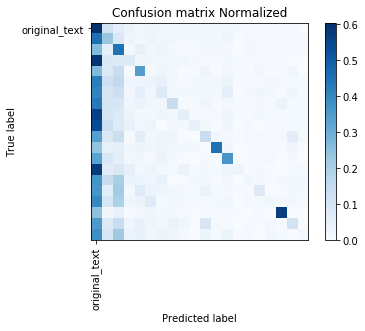

In [26]:
evaluate_prediction(predictions, y_test)

Greater than 90% accuracy is great for our first model!

__Why did it work__? Twitter benchmark users of any particular category tweet in a very distinct way. As we saw above, users in the "Music" category are more likely to use words like "performance" or "album" more. Similarly users in the "Politics" category tend to use words like "policy" more. Bag of words can catch this quite brilliantly! We can see evidence of this below.

In [27]:
most_influential_words(clf_count, count_vectorizer, category_index=9)

['kiss',
 'tequila',
 'goodnight',
 'bae',
 'boo',
 'babe',
 'goodbye',
 'wcw',
 'carpet',
 'study']

# [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) with LogisticRegression
This is a slightly more advanced method than bag of words. Bag of words needs good preprocessing more than TF-IDF as it is a raw count. However TF-IDF can reduce the weight for highly occuring terms such as 'the' by dividing by normalizing it with the number of documents it occurs in.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [30]:
train_tfidf_features = tfidf_vectorizer.fit_transform(' '.join(text) for text in X_train['original_text'])

In [31]:
clf_tfidf = LogisticRegression()

In [32]:
clf_tfidf = clf_tfidf.fit(train_tfidf_features, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
test_tfidf_features = tfidf_vectorizer.transform(' '.join(text) for text in X_test['original_text'])

In [34]:
predictions = clf_tfidf.predict(test_tfidf_features)

accuracy 0.3094
confusion matrix
 [[1568  222  144   35   26   17   19   17    9   11    6   18   19    5
     2    2    2   24    5    1]
 [ 576  262  109    5    9   15   10   13    2    1    9    9   19    1
     0    3    2    8    3    0]
 [ 339   72  537    5   31    6    7    3    4    0    6    8    8    0
     7    4    0    6    5    0]
 [ 404   45   46   27   12   11    5    3    2    4    4    1    4    1
     1    0    1    3    3    0]
 [ 160   43   87    1  172    4    7    2    1    1    7    4    7    0
     1    0    0    3    3    1]
 [ 255   62   85    4    6    9    6    5    2    3    3    3   14    0
     1    1    0    3    1    0]
 [ 195   48   69    4   19    5   21    4    3    1    3    4   23    0
     2    7    0    1    1    0]
 [ 212   43   42    3   12    7    1   37    2    0    2    1    5    0
     0    0    0   12    0    0]
 [ 248   35   29    8    5    2    1    2   13    1    3    0    7    1
     0    2    0    1    1    0]
 [ 216   45   28    4

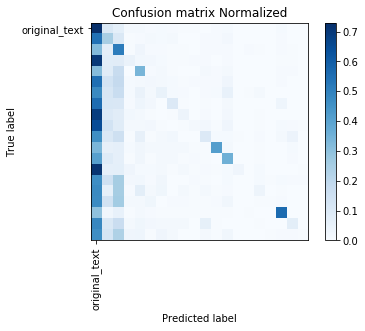

In [35]:
evaluate_prediction(predictions, y_test)

In [36]:
most_influential_words(clf_tfidf, count_vectorizer, category_index=9)

['love',
 'kiss',
 'bae',
 'boo',
 'babe',
 'thanks',
 'thank',
 'wcw',
 'birthday',
 'miss']

Even this model gives us a wonderful accuracy!

__However let's try some more methods__. First we will do some topic modeling. After all the package we will be using is called "Gensim-Topic Modeling for Humans"! Topic modeling can help find hidden structure in our data and thus is very useful in visualizing our dataset. It can in turn also be used for classification and dimensionality reduction among many of it's other uses.

# Let's do some topic modelling
Essentially we're trying to find out the topics of the tweets which the user is tweeting about. Since topic models come up with topic distributions, they can probably help us in this task.

Let's see if we can use topic models to find some hidden structure in our data first!

### Setting up our standard gensim corpus
You can refer to the short tutorial [here](https://radimrehurek.com/gensim/tut1.html) for reference as to how a standard gensim corpus is set. 

In [37]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

unable to import 'smart_open.gcs', disabling that module


In [38]:
dictionary = Dictionary(X_train['original_text'])

In [39]:
print(dictionary)

Dictionary(50262 unique tokens: ['bud', 'kent', 'reunited', 'state', 'cred']...)


In [40]:
corpus = [dictionary.doc2bow(text) for text in X_train['original_text']]

### [LSI](https://radimrehurek.com/gensim/models/lsimodel.html) (Latent Semantic Indexing)
LSI uses Singular Value Decomposition (SVD) for topic modeling. It can rank topics automatically but needs the `num_topics` parameter to be entered for the number of latent dimensions requested. There is currently an open [issue](https://github.com/RaRe-Technologies/gensim/issues/28) in gensim where an automatic number of topics "chooser" has been proposed.

In [41]:
from gensim.models import LsiModel

In [42]:
lsim = LsiModel(corpus=corpus, num_topics=100, id2word=dictionary)

In [43]:
lsim.show_topics(num_topics=10)

[(0,
  '0.962*"user" + 0.191*"â" + 0.079*"love" + 0.052*"new" + 0.042*"day" + 0.035*"happy" + 0.033*"wa" + 0.032*"night" + 0.030*"ãƒ" + 0.029*"thanks"'),
 (1,
  '0.974*"â" + -0.210*"user" + 0.042*"love" + 0.024*"day" + 0.020*"new" + 0.019*"happy" + 0.015*"one" + 0.013*"wa" + 0.013*"best" + 0.012*"friend"'),
 (2,
  '0.754*"new" + 0.502*"york" + 0.307*"love" + 0.104*"happy" + -0.101*"user" + 0.089*"day" + -0.071*"â" + 0.067*"city" + 0.063*"time" + 0.046*"nyc"'),
 (3,
  '0.850*"love" + -0.312*"new" + -0.225*"york" + 0.180*"happy" + 0.124*"day" + 0.096*"birthday" + 0.080*"much" + -0.079*"user" + -0.067*"â" + 0.062*"best"'),
 (4,
  '0.605*"day" + 0.496*"happy" + -0.374*"love" + 0.195*"birthday" + 0.132*"wa" + 0.128*"best" + 0.116*"one" + 0.107*"good" + 0.101*"beach" + 0.090*"im"'),
 (5,
  '0.678*"happy" + -0.411*"day" + 0.338*"birthday" + -0.247*"wa" + -0.223*"night" + -0.156*"last" + -0.128*"time" + -0.123*"beach" + -0.121*"good" + -0.082*"today"'),
 (6,
  '-0.614*"day" + 0.402*"night" + 0

In [44]:
lsimtopics = lsim.show_topics(formatted=False)

### [HDP](https://radimrehurek.com/gensim/models/hdpmodel.html) (Hierarchical Dirichlet Process)
An HDP model is fully unsupervised. It can also determine the ideal number of topics through posterior inference. This property of HDP is particularly useful when in the "online" mode where the number of documents keep streaming and hence the number of topics becomes hard to determine before-hand as in LDA.

In [45]:
from gensim.models import HdpModel

In [46]:
hdpm = HdpModel(corpus=corpus, id2word=dictionary)

In [47]:
hdpm.show_topics()

[(0,
  '0.011*user + 0.004*â + 0.004*love + 0.004*new + 0.003*day + 0.003*beach + 0.003*time + 0.003*york + 0.003*happy + 0.002*im + 0.002*one + 0.002*best + 0.002*wa + 0.002*friend + 0.001*good + 0.001*last + 0.001*nyc + 0.001*birthday + 0.001*see + 0.001*city'),
 (1,
  '0.011*user + 0.005*â + 0.005*love + 0.004*new + 0.003*happy + 0.003*day + 0.003*york + 0.002*wa + 0.002*best + 0.002*good + 0.002*im + 0.002*friend + 0.002*great + 0.002*time + 0.001*one + 0.001*night + 0.001*birthday + 0.001*see + 0.001*u + 0.001*beautiful'),
 (2,
  '0.007*user + 0.003*â + 0.002*love + 0.002*new + 0.002*wa + 0.002*beach + 0.002*day + 0.001*happy + 0.001*ãƒ + 0.001*san + 0.001*city + 0.001*one + 0.001*night + 0.001*good + 0.001*im + 0.001*christmas + 0.001*york + 0.001*time + 0.001*girl + 0.001*got'),
 (3,
  '0.007*user + 0.003*â + 0.002*love + 0.002*day + 0.002*new + 0.001*night + 0.001*wa + 0.001*happy + 0.001*time + 0.001*one + 0.001*like + 0.001*im + 0.001*good + 0.001*see + 0.001*best + 0.001*î +

HDP surely comes up with better, more human interpretable topics as we can see. There are topics which clearly talk about sports, others which only have words related to politics or some which relate to travel. As we saw above in LSI, the topics were a bit mixed up. HDP doesn't seem to mix it up as much.

In [48]:
hdpmtopics = hdpm.show_topics(num_topics=-1, num_words=10, formatted=False)

### [LDA](https://radimrehurek.com/gensim/models/ldamodel.html) (Latent Dirichlet Allocation)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei.
<img src="images/blei_news.png">

In [49]:
ldam = LdaModel(corpus=corpus, num_topics=100, id2word=dictionary)

In [50]:
ldam.show_topics()

[(13,
  '0.267*"dont" + 0.108*"let" + 0.065*"play" + 0.063*"link" + 0.059*"iâ" + 0.056*"enjoying" + 0.052*"bio" + 0.037*"cleveland" + 0.014*"worry" + 0.012*"nola"'),
 (66,
  '0.468*"year" + 0.063*"mall" + 0.043*"shirt" + 0.041*"wearing" + 0.019*"killing" + 0.018*"lexington" + 0.007*"ky" + 0.001*"fayette" + 0.001*"time" + 0.000*"last"'),
 (7,
  '0.253*"big" + 0.132*"rock" + 0.110*"beauty" + 0.076*"hour" + 0.047*"three" + 0.024*"self" + 0.014*"user" + 0.013*"original" + 0.010*"drove" + 0.000*"â"'),
 (28,
  '0.188*"w" + 0.130*"studio" + 0.089*"user" + 0.072*"monday" + 0.072*"dance" + 0.070*"white" + 0.063*"said" + 0.026*"workout" + 0.024*"photoshoot" + 0.021*"photographer"'),
 (55,
  '0.188*"airport" + 0.161*"nice" + 0.136*"meet" + 0.021*"hahaha" + 0.008*"laguardia" + 0.006*"lga" + 0.000*"city" + 0.000*"new" + 0.000*"york" + 0.000*"cold"'),
 (1,
  '0.135*"already" + 0.124*"may" + 0.107*"almost" + 0.105*"woman" + 0.034*"sugar" + 0.012*"posting" + 0.012*"bite" + 0.010*"known" + 0.004*"pregn

`LdaModel` also comes up with decent topics. We can decipher some topics by the word distributions.

In [51]:
ldamtopics = ldam.show_topics(num_topics=-1, formatted=False)

# Topic Coherence
<img src='images/pipeline.png'>
Topic coherence is a way to quantify the human interpretability of the topics. Simply enter the __topics 't'__ and you get __coherence value 'c'__ as the output! The topic coherence pipeline recently got merged into gensim which was based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al.

This is a great way to compare individual topics and can be extended to comparing different topic models as well. We will be doing this later on in this tutorial.

To know more about topic coherence you can read my blog [here](https://rare-technologies.com/what-is-topic-coherence/) where I have to tried to give an introductory explanation of how topic coherence works.

### Finding optimal number of topics
As we saw above, `LdaModel` requires the number of topics to be entered for fitting it. This is one of the problem of LDA as knowing the number of topics beforehand can be a challenging task especially in an online setting. Traditionally, perplexity has been used to find out the optimum number of topics. We will be using topic coherence instead. The logic is pretty simple in that: "Let's select the number of topics which we can understand easily".

In [52]:
import operator
from gensim.models import CoherenceModel

In [53]:
BASE = 6  # base number of topics for graph evaluation

In [54]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    if limit < BASE:
        raise ValueError("Please enter limit > %d. You entered %d" % (BASE, limit))
    c_v = []
    lm_list = []
    for num_topics in range(BASE, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(6, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

We iteratively train LdaModels for different number of topics ranging from 6 to 15. Topics lesser than 6 might not make sense however we should be getting the ideal value around 8 as the number of categories we have are 8.

__Warning__: Can take quite long to compute. If you want to reduce the amount of time taken here, you can reduce the limit or better, change the coherence algorithm to `u_mass` instead. However it has been experimentally proven that `c_v` correlates best with human interpretation.

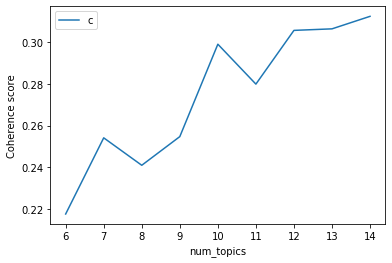

Wall time: 1h 40min 7s


In [55]:
%%time
lm_list, c_v = evaluate_graph(dictionary, corpus, X_train['original_text'], 15)

In [56]:
ldam_tc = lm_list[np.argmax(c_v)]  # Select the LdaModel corresponding to the best coherence value

In [57]:
ldam_tc.show_topics(num_topics=-1)

[(0,
  '0.046*"user" + 0.032*"love" + 0.024*"baby" + 0.019*"thank" + 0.018*"work" + 0.017*"u" + 0.017*"bar" + 0.016*"amazing" + 0.015*"cant" + 0.013*"â"'),
 (1,
  '0.041*"school" + 0.034*"high" + 0.021*"family" + 0.021*"stadium" + 0.018*"north" + 0.013*"love" + 0.013*"keep" + 0.012*"sunset" + 0.012*"around" + 0.011*"thanksgiving"'),
 (2,
  '0.050*"happy" + 0.042*"user" + 0.037*"one" + 0.032*"birthday" + 0.022*"favorite" + 0.019*"love" + 0.018*"â" + 0.012*"see" + 0.012*"im" + 0.011*"day"'),
 (3,
  '0.058*"university" + 0.032*"florida" + 0.021*"house" + 0.020*"still" + 0.019*"studio" + 0.015*"picture" + 0.015*"crazy" + 0.014*"center" + 0.013*"state" + 0.013*"coffee"'),
 (4,
  '0.058*"park" + 0.051*"christmas" + 0.020*"state" + 0.015*"merry" + 0.014*"magic" + 0.013*"downtown" + 0.012*"tree" + 0.010*"wedding" + 0.010*"michigan" + 0.010*"ca"'),
 (5,
  '0.039*"morning" + 0.034*"good" + 0.022*"chicago" + 0.017*"brooklyn" + 0.015*"heart" + 0.015*"hill" + 0.015*"red" + 0.014*"hotel" + 0.013*"su

In [58]:
ldam_tctopics = ldam_tc.show_topics(num_topics=-1, formatted=False)

### LDA as LSI
As we saw above, LSI can automatically rank topics. We can actually do the same with LDA also by making it work with the topic coherence pipeline. We rank individual topics based on their human interpretability.

We will be going one step further here and making a new LDA model by using only the best topics from the first LDA model. An "LDA migration" of sorts! This can be done by selecting the `alphas` and `betas` corresponding to only the best topics from the first LDA model and transferring them onto the new model.

In [59]:
def ret_top_model(num_topics):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can create another topic model from only the most coherent n topics
    from the LDAmodel.
    
    Parameters:
    ----------
    num_topics: Number of top topics for new LdaModel.
    
    Returns:
    -------
    refined_lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    lm = LdaModel(corpus=corpus, id2word=dictionary)
    coherence_values = {}
    doc = []
    for n, topic in lm.show_topics(num_topics=-1, formatted=False):
        topic = [word for word, _ in topic]
        cm = CoherenceModel(topics=[topic], texts=X_train['original_text'], dictionary=dictionary)
        coherence_values[n] = cm.get_coherence()
    top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)[:num_topics]
    top_topics = [t for t, c in top_topics]
    alpha = lm.alpha[top_topics]
    beta = lm.expElogbeta[top_topics, :]
    refined_lm = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha)
    refined_lm.expElogbeta[:] = beta
    return refined_lm

__Warning__: Can take some time to run

In [60]:
%%time
lda_lsim = ret_top_model(BASE + np.argmax(c_v))  # Using the value we found above

KeyboardInterrupt: 

In [61]:
lda_lsim.show_topics(-1)

NameError: name 'lda_lsim' is not defined

HDP model still seems like the best one yet....

In [ ]:
lda_lsimtopics = lda_lsim.show_topics(num_topics=-1, formatted=False)

Let's transfer out HDP model into an LDA model. We can do these by copying over the corresponding alphas and betas into the LDA model. This will also help us calculate topic inferences easily if this turns out to be the best LDA model so far.

In [62]:
alpha, beta = hdpm.hdp_to_lda()
num_topics = len(hdpmtopics)

In [63]:
%%time
lda_hdp = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha)
lda_hdp.expElogbeta[:] = beta

AssertionError: Invalid alpha shape. Got shape (150,), but expected (0, )

### Evaluating all topic models
Finally, we will be using the topic coherence pipeline to compare all the topic models we have created so far. Till now we have only been qualitatively comparing the models. The topic coherence pipeline allows us to quantitatively compare the different topic models. 

In [65]:
#lsimtopics = [[word for word, prob in topic] for topicid, topic in lsimtopics]
hdpmtopics = [[word for word, prob in topic] for topicid, topic in hdpmtopics]
ldamtopics = [[word for word, prob in topic] for topicid, topic in ldamtopics]
ldam_tctopics = [[word for word, prob in topic] for topicid, topic in ldam_tctopics]
lda_lsimtopics = [[word for word, prob in topic] for topicid, topic in lda_lsimtopics]

ValueError: too many values to unpack (expected 2)

In [ ]:
%%time
lsi_coherence = CoherenceModel(topics=lsimtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
hdp_coherence = CoherenceModel(topics=hdpmtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_coherence = CoherenceModel(topics=ldamtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lm_coherence = CoherenceModel(topics=ldam_tctopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_lsi_coherence = CoherenceModel(topics=lda_lsimtopics, texts=X_train['original_text'], dictionary=dictionary, window_size=110).get_coherence()
lda_hdp_coherence = CoherenceModel(model=lda_hdp, texts=X_train['original_text'], dictionary=dictionary).get_coherence()

In [ ]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [ ]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence, lda_hdp_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_TC', 'LDA_LSI', 'LDA_HDP'])

Our intuition was correct! HDP model turned out to be the best one and the transferred HDP model turned out to be the best LDA model. I would have liked our optimal topics and lda_lsi to perform better but we can be happy that it at least performs better than vanilla LDA!

__DO REMEMBER__ that these values and topic models only correspond to this dataset and can vary accross different datasets. In fact since LDA models are probabilistic, they can vary a lot across runs too! We could have done better in LDA tuning however this was a tutorial on how topic coherence in particular can be used for LDA tuning. 
I have observed that HDP models generally perform better when each `text` within `texts` has a lot of tokens. You will notice that the comparison turned out to be very different in my [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb).

We can infer topic distributions from individual word tokens

In [ ]:
lda_hdp[dictionary.doc2bow(['jimmy', 'fallon', 'entertainment'])]

In [ ]:
lda_hdp.show_topic(43, topn=10)

# LDA topic inference for classification
In this tutorial we will be using our best LDA model from above for inference and classification. When we use LDA for inference it gives large probabilities for some topics but negligible for the others. This is how it looks like:
<img src='images/inference.jpg'>
<center> _Image taken from Blei's video on LDA_ </center>

__This is the pipeline we're following for LDA inference classification__ (wanted to see how well I can use the pencil in gimp):
<img src='images/lda_dim_red.png'>
P, B = Preprocessing, bigram collocation

LDA = LDA model for inference

CLF = Classifier

As we can see above in the graph, LDA inference yields positive values for only some topics and negligible values for the others. We can assume them to be 0 to create our dataframe.

In [ ]:
def ret_lda_features(ldamodel, texts, num_topics):
    """
    Function to return LDA inference features for texts.
    
    Parameters:
    ----------
    ldamodel: LDA model to infer docs
    texts: Texts to be inferred
    num_topics: Number of topics. Will determine columns in dataframe
    
    Returns:
    -------
    lda_features: LDA features dataframe
    """
    lda_features = pd.DataFrame()
    for message in texts:
        features = np.zeros(shape=(1, num_topics))
        inference = ldamodel[dictionary.doc2bow(message)]
        for tid, val in inference:
            features[:, tid] = val
        features = pd.DataFrame(features)
        lda_features = lda_features.append(features, ignore_index=True)
    return lda_features

In [ ]:
train_lda_features = ret_lda_features(lda_hdp, train_texts, num_topics)

In [ ]:
train_lda_features.shape

In [ ]:
train_lda_features.head()

In [ ]:
clf_lda = LogisticRegression()

In [ ]:
clf_lda = clf_lda.fit(train_lda_features, categories)

In [ ]:
test_lda_features = ret_lda_features(lda_hdp, test_texts, num_topics)

In [ ]:
test_lda_features.head()

In [ ]:
predictions = clf_lda.predict(test_lda_features)

In [ ]:
evaluate_prediction(predictions, test['category'])

__Exercise__: Plug in our HDP model above instead of LDA model and see what's the difference

Turns out, our TF-IDF and bag of words based models outperform this method. However no gensim tutorial is complete without word embeddings. Let's try word embeddings now!